## Chemprot large scale generalisatiom

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/chemprot/predictions_chemprot-abstract-bert-f1-2022-07-30-22-34-07-969/2022080621/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/chemprot/chemprot_abstract_train.json"



In [3]:
is_download_files= False

In [4]:
label_order = ["NEGATIVE",
               "CPR:3",
               "CPR:4",
               "CPR:5",
               "CPR:6",
               "CPR:9"]
pos_labels = list( filter(lambda x: x != 'NEGATIVE', label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {"NEGATIVE" : "Negative class"}

In [5]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


In [9]:
!ls -l $local_temp_pred_dir | wc -l

      11


In [10]:
default_threshold =  0.95
threshold_config =  {l: { "confidence":default_threshold}  for l in label_order}



In [11]:
threshold_config

{'NEGATIVE': {'confidence': 0.95},
 'CPR:3': {'confidence': 0.95},
 'CPR:4': {'confidence': 0.95},
 'CPR:5': {'confidence': 0.95},
 'CPR:6': {'confidence': 0.95},
 'CPR:9': {'confidence': 0.95}}

In [12]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        list_df.append(df)
    return pd.concat(list_df)


In [13]:
def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id", "participant1_id", "participant2_id", "participant1", "participant2"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t["confidence"]
            conf_std_median = 1.0
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            df_sub = df.query(high_qry)
            sample = min(1000, len(df_sub) )
            high_quality_frames_per_interaction.append(df_sub.sample(n=sample))


            # Low quality filter query
            conf_min = 0.8
            conf_std_min = 0.0
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_min)
            df_low = df.query(low_qry)
            sample=min(1000, len(df_low) )
            low_quality_frames_per_interaction.append(df_low.sort_values(by=["prediction", "confidence_std"]).head(n=sample))
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [14]:
# def get_partipants_key_raw(participants):
    
#     participant_names = []
#     for p in participants:
        
#         participant_names.append(str(p["name"]))
        
        
#     result = frozenset( list(filter (lambda x: x is not None, participant_names)))
    
#     return result


# def is_in_training(df, training_df):
#     training_participants_pred = pd.DataFrame()
#     training_participants_pred["abstract_id"] = training_df["abstract_id"]
#     training_participants_pred["participants"] = training_df["participants"].apply(get_partipants_key_raw)
#     training_participants_pred["prediction"] = training_df["label"]
#     training_participants_pred["interaction-participants"] = training_participants_pred[["prediction", "participants"]].apply(tuple, axis=1)
#     training_participants_pred["abstract-interaction-participants"] = training_participants_pred[["prediction","participants","abstract_id" ]].apply(tuple, axis=1)


#     df_particpiants_pred = pd.DataFrame()
#     df_particpiants_pred["pubmedId"] = df["pubmedId"]
#     df_particpiants_pred["participants"] = df[["participant2Id", "participant1Id"]].apply(frozenset, axis=1)
#     df_particpiants_pred["prediction"] = df["prediction"]
#     df_particpiants_pred["ptm-ppi"] = df_particpiants_pred[["prediction","participants" ]].apply(tuple, axis=1)
#     df_particpiants_pred["ptm-ppi-pubmed"] = df_particpiants_pred[["prediction","participants","pubmedId" ]].apply(tuple, axis=1)
 
#     result = pd.DataFrame()
#     result["is_in_train_ptmppi"] =  df_particpiants_pred["ptm-ppi"].isin(training_participants_pred["ptm-ppi"])
#     result["is_in_train_record"]=  df_particpiants_pred["ptm-ppi-pubmed"].isin(training_participants_pred["ptm-ppi-pubmed"])
    
    
#     return result


def is_in_training_pubmed(df, training_df):
    return df["abstract_id"].isin(training_df["abstract_id"])

In [15]:
download_file(s3_training, local_temp_wk_dir)
training_data_file = os.path.join(local_temp_wk_dir, s3_training.split("/")[-1])
data_training_full_df = pd.read_json(training_data_file)

In [16]:
%%time 


df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir)
df_high_quality_threshold[ "RecordInTrainingData"] = is_in_training_pubmed( df_high_quality_threshold, data_training_full_df)
df_summary["RecordInTrainingData"] = is_in_training_pubmed( df_summary, data_training_full_df)
df_low_quality_threshold[ "RecordInTrainingData"]= is_in_training_pubmed( df_low_quality_threshold, data_training_full_df)

CPU times: user 1min 2s, sys: 2min 32s, total: 3min 35s
Wall time: 11min 3s


In [17]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [18]:
df_high_quality_threshold.shape, df_summary.shape

((40120, 22), (818506, 9))

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


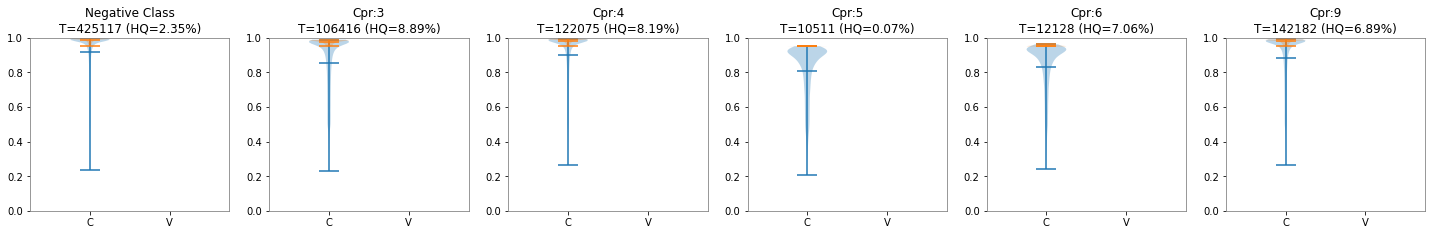

In [19]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [20]:
df_low_quality_threshold["prediction"].value_counts()

NEGATIVE    10000
CPR:9        9186
CPR:3        9108
CPR:4        8852
CPR:5        3534
CPR:6        3343
Name: prediction, dtype: int64

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


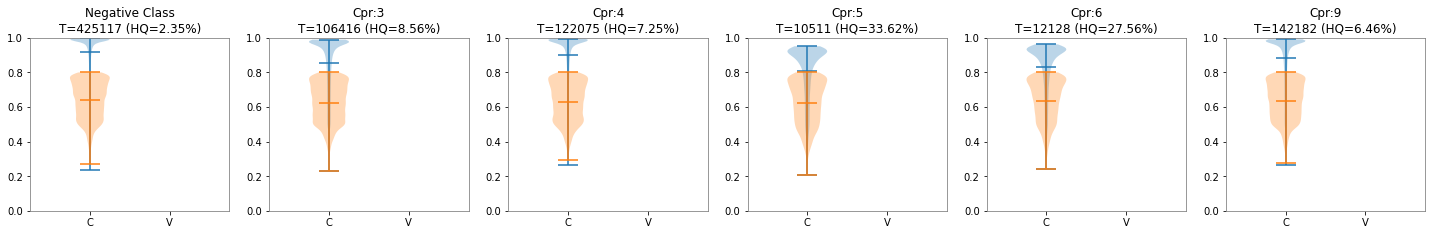

In [21]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_low_quality_threshold, gs[0])



In [22]:
df_summary.shape

(818506, 9)

In [24]:
df_summary[["confidence","prediction"]].groupby("prediction").describe().T

prediction                CPR:3          CPR:4         CPR:5         CPR:6  \
confidence count  106416.000000  122131.000000  10511.000000  12128.000000   
           mean        0.853138       0.898004      0.806877      0.834204   
           std         0.162013       0.144485      0.153540      0.141092   
           min         0.228579       0.266677      0.206309      0.241060   
           25%         0.759787       0.868698      0.727963      0.779481   
           50%         0.935804       0.973022      0.874998      0.897686   
           75%         0.978127       0.989636      0.923808      0.935788   
           max         0.989341       0.995148      0.951501      0.962043   

prediction                CPR:9       NEGATIVE  
confidence count  142183.000000  425137.000000  
           mean        0.882228       0.915688  
           std         0.147825       0.130484  
           min         0.262633       0.236930  
           25%         0.830135       0.905639  
           50%         0.959655       0.980195  
           75%         0.984062       0.992291  
           max         0.991493       0.996282

In [25]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold):
    
    participants_cols = ["participant1_id", "participant2_id"]
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    df_full["participants"] = df_full[participants_cols].apply(frozenset, axis=1)
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()
    df_high_quality_threshold["participants"] = df_high_quality_threshold[participants_cols].apply(frozenset,
                                                                                                   axis=1)

        
    
    summary_df = pd.DataFrame(df_full
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    summary_unique_df = pd.DataFrame(df_full\
                          .groupby([ "prediction", "participants"])\
                          .size()\
                          .groupby(level=0).size())\
                          .rename(columns={0: "all_count_unique"})
    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    thresh_unique_df = pd.DataFrame(df_high_quality_threshold\
              .groupby([ "prediction", "participants"])\
              .size()\
              .groupby(level=0).size())\
              .rename(columns={0: "thresh_count_unique"})
            
    
   
    
    
    dfs = [summary_df, summary_unique_df, thresh_df, thresh_unique_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold)

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrrrr}
\toprule
{} &  all\_count &  all\_count\_unique &  thresh\_count &  thresh\_count\_unique \\
prediction &            &                   &               &                      \\
\midrule
CPR:3      &     106416 &            102126 &          9456 &                 9423 \\
CPR:4      &     122075 &            115905 &          9992 &                 9930 \\
CPR:5      &      10511 &             10464 &             7 &                    7 \\
CPR:6      &      12128 &             12065 &           856 &                  856 \\
CPR:9      &     142182 &            134391 &          9802 &                 9757 \\
NEGATIVE   &     425117 &            356838 &         10000 &                 9936 \\
Total      &     818429 &            731789 &         40113 &                39909 \\
\bottomrule
\end{tabular}

CPU times: user 23.7 s, sys: 2min 8s, total: 2min 31s
Wall time: 8min 37s


,all_count,all_count_unique,thresh_count,thresh_count_unique
prediction,,,,
CPR:3,106416,102126,9456,9423
CPR:4,122075,115905,9992,9930
CPR:5,10511,10464,7,7
CPR:6,12128,12065,856,856
CPR:9,142182,134391,9802,9757
NEGATIVE,425117,356838,10000,9936
Total,818429,731789,40113,39909


In [26]:
df_high_quality_threshold.groupby(["prediction"]).size()

prediction
CPR:3        9456
CPR:4        9999
CPR:5           7
CPR:6         856
CPR:9        9802
NEGATIVE    10000
dtype: int64

In [27]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [28]:
from utils.static_markers_chemprot_abstract import StaticMarkerChemprotAbstract

local_file_high_q_sample = os.path.join(local_temp, "highquality_sample.json")
local_file_low_q_sample = os.path.join(local_temp, "lowquality_sample.json")



StaticMarkerChemprotAbstract().create(df_high_quality_threshold, local_file_high_q_sample,  additional_cols= ",".join( list(df_high_quality_threshold.columns)))
StaticMarkerChemprotAbstract().create(df_low_quality_threshold, local_file_low_q_sample,  additional_cols= ",".join( list(df_low_quality_threshold.columns)))




In [29]:
upload_file( local_file_high_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))
upload_file( local_file_low_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))



In [30]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
from utils.static_markers_ppi_multiclass import StaticMarkerPpiMulticlass
import pandas as pd
import tempfile

def get_sim_scores(ref_file_or_df, target_file_or_df, n_gram, additional_target_cols):
    marker_ref_file = tempfile.mkstemp()[1]
    marker_target_file = tempfile.mkstemp()[1]


    StaticMarkerChemprotAbstract().create(ref_file_or_df, marker_ref_file)
    StaticMarkerChemprotAbstract().create(target_file_or_df, marker_target_file,  additional_cols= ",".join( additional_target_cols))
    
    
    df_ref_marker = pd.read_json(marker_ref_file)
    df_target_marker = pd.read_json(marker_target_file)
    
    comparer =  SimilarityComparer(n_gram=n_gram, max_features=1050)
    comparison_result = comparer(df_ref_marker["x"].tolist(), df_target_marker["x"].tolist())
    
    sim_score = comparison_result[0]
    
    df_target_marker["sim_score"]  = comparison_result[0]
    return df_target_marker
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

In [31]:
df_high_quality_threshold.shape

(40120, 22)

In [32]:
df_sim_score_high = get_sim_scores(data_training_full_df, df_high_quality_threshold, n_gram=1, additional_target_cols=list(df_high_quality_threshold.columns))

df_sim_score_high.head()


,x,y,y_raw,abstract_id,abstract,participant1_id,participant1,participant2_id,participant2,annotations,relationship_type,relationship_group,is_eval,label,NEGATIVE,CPR:3,CPR:4,CPR:5,CPR:6,CPR:9,prediction,confidence,confidence_std,raw_confidence,RecordInTrainingData,sim_score
0,PURPOSE: Most recurrent squamous cell carcinom...,0,NEGATIVE,19996201,PURPOSE: Most recurrent squamous cell carcinom...,T12367,"{'abstract_id': '19996201', 'id': 'T12367', 'e...",T12374,"{'abstract_id': '19996201', 'id': 'T12374', 'e...","[{'abstract_id': '19996201', 'id': 'T12357', '...",NEGATIVE,NEGATIVE,Y,NEGATIVE,0.985025,0.002267,0.007854,0.000583,0.000635,0.003636,NEGATIVE,0.985025,NaN,[0.9850245714],False,0.559517
1,The GENEIG1 regulatory network responds to cel...,0,NEGATIVE,19996285,The p53 regulatory network responds to cellula...,T12775,"{'abstract_id': '19996285', 'id': 'T12775', 'e...",T12773,"{'abstract_id': '19996285', 'id': 'T12773', 'e...","[{'abstract_id': '19996285', 'id': 'T12772', '...",NEGATIVE,NEGATIVE,Y,NEGATIVE,0.993875,0.002226,0.000890,0.000961,0.000794,0.001254,NEGATIVE,0.993875,NaN,[0.9938748479],False,0.276699
2,The biogenesis of GENEIG8 initiates with synth...,0,NEGATIVE,19995914,The biogenesis of cytochrome c oxidase initiat...,T11070,"{'abstract_id': '19995914', 'id': 'T11070', 'e...",T11060,"{'abstract_id': '19995914', 'id': 'T11060', 'e...","[{'abstract_id': '19995914', 'id': 'T11047', '...",NEGATIVE,NEGATIVE,Y,NEGATIVE,0.993839,0.001185,0.000657,0.000947,0.000962,0.002410,NEGATIVE,0.993839,NaN,[0.9938389659],False,0.524446
3,GENEIG1 (IgY) was purified from hen egg yolk w...,0,NEGATIVE,19994898,Immunoglobulin Y (IgY) was purified from hen e...,T8429,"{'abstract_id': '19994898', 'id': 'T8429', 'en...",T8428,"{'abstract_id': '19994898', 'id': 'T8428', 'en...","[{'abstract_id': '19994898', 'id': 'T8425', 'e...",NEGATIVE,NEGATIVE,Y,NEGATIVE,0.976613,0.003182,0.003818,0.001398,0.001184,0.013806,NEGATIVE,0.976613,NaN,[0.9766132832000001],False,0.278016
4,GENEIG7 and GENEPART1 signaling events are ess...,0,NEGATIVE,19966856,Notch3 and pTalpha signaling events are essent...,T335,"{'abstract_id': '19966856', 'id': 'T335', 'ent...",T346,"{'abstract_id': '19966856', 'id': 'T346', 'ent...","[{'abstract_id': '19966856', 'id': 'T334', 'en...",NEGATIVE,NEGATIVE,Y,NEGATIVE,0.967970,0.023446,0.005636,0.000934,0.000652,0.001362,NEGATIVE,0.967970,NaN,[0.9679698944],False,0.488241


<AxesSubplot:>

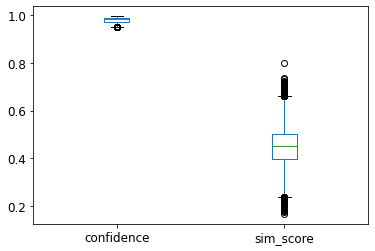

In [33]:
df_sim_score_high[["confidence","sim_score"]].plot.box()

<AxesSubplot:>

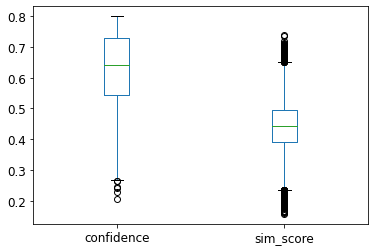

In [34]:
df_sim_score_low = get_sim_scores(data_training_full_df, df_low_quality_threshold, n_gram=1, additional_target_cols=list(df_low_quality_threshold.columns))
df_sim_score_low[["confidence","sim_score"]].plot.box()

In [35]:
def plot_box_sim_scores_confidence(df_high, df_low):
    p_unique = sorted(list(df_high["prediction"].unique()))
    
    _, axes = plt.subplots(1, len(p_unique), figsize=(30 ,8))
    
    for i, l in enumerate(p_unique):
        dh = df_high.query(f"prediction == '{l}'")
        dl = df_low.query(f"prediction == '{l}'")
        
        dl = dl[["confidence", "sim_score"]]
        dh = dh[["confidence", "sim_score"]]                   
                    
        
        data = dh.values.T.tolist()
        data.extend(dl.values.T.tolist())
      
        ax=axes[i]
        ax.boxplot(data, showmeans=True)
        ax.set_title(l)
        ax.set_xticklabels(["HC","HS", "LC", "LH"])


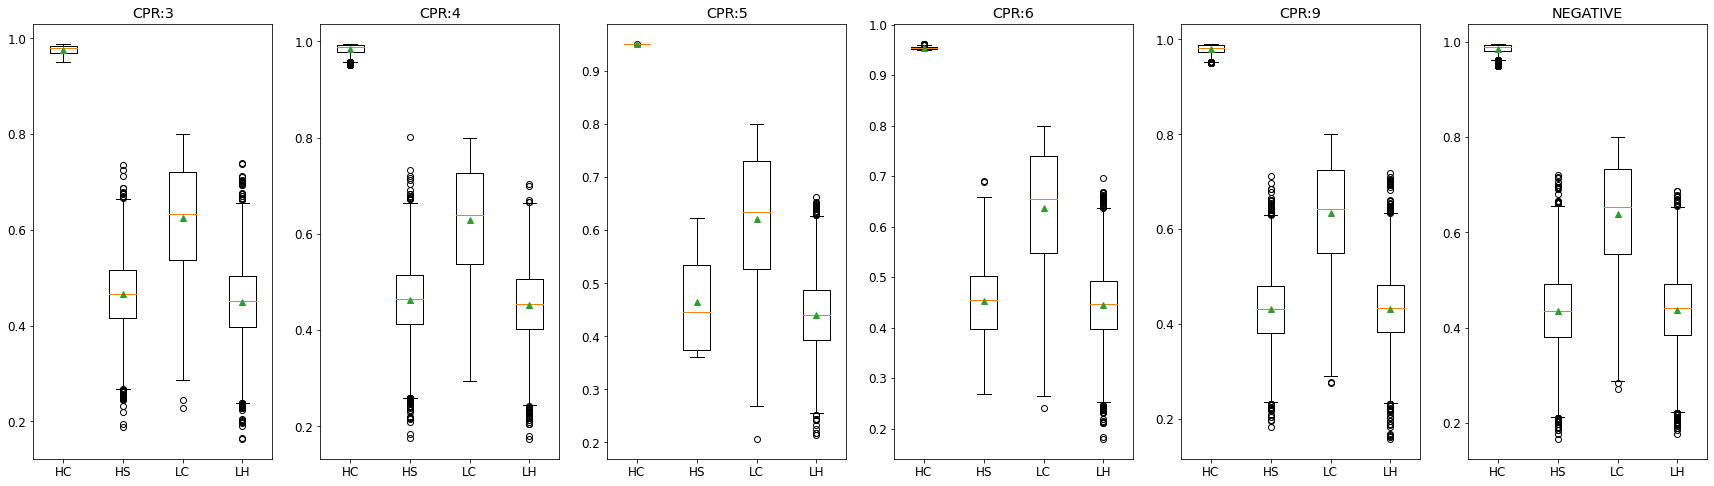

In [36]:
plot_box_sim_scores_confidence(df_sim_score_high, df_sim_score_low)

In [37]:
df_sim_score_high[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
CPR:3          9456.0  0.976172  0.010041  0.950009  0.970041  0.979384   
CPR:4          9999.0  0.983364  0.011112  0.950052  0.978035  0.987739   
CPR:5             7.0  0.950522  0.000463  0.950118  0.950259  0.950454   
CPR:6           856.0  0.953340  0.002378  0.950013  0.951399  0.952974   
CPR:9          9802.0  0.979067  0.010514  0.950011  0.973102  0.982908   
NEGATIVE      10000.0  0.985497  0.011174  0.950002  0.980983  0.990150   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
CPR:3       0.984396  0.988898    9456.0  0.465121  0.072157  0.188798   
CPR:4       0.991848  0.995130    9999.0  0.462219  0.074501  0.174964   
CPR:5       0.950532  0.951501       7.0  0.463729  0.108927  0.361397   
CPR:6       0.954844  0.962043     856.0  0.453454  0.072726  0.269130   
CPR:9       0.987402  0.991089    9802.0  0.430760  0.072807  0.182349   
NEGATIVE    0.993804  0.996178   10000.0  0.434711  0.081053  0.165722   

                                                    
                 25%       50%       75%       max  
prediction                                          
CPR:3       0.416204  0.466879  0.515770  0.734875  
CPR:4       0.412363  0.463820  0.514428  0.801070  
CPR:5       0.374139  0.446010  0.533640  0.623139  
CPR:6       0.397885  0.454899  0.502272  0.690614  
CPR:9       0.380844  0.430542  0.480349  0.711084  
NEGATIVE    0.379252  0.435378  0.490570  0.720941

In [38]:
df_sim_score_low[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
CPR:3          9108.0  0.625381  0.111277  0.228579  0.537281  0.632626   
CPR:4          8852.0  0.628875  0.111941  0.295021  0.538340  0.639454   
CPR:5          3534.0  0.621266  0.123736  0.206309  0.526011  0.634494   
CPR:6          3343.0  0.636352  0.117920  0.241060  0.547004  0.655262   
CPR:9          9186.0  0.633253  0.107808  0.276210  0.548957  0.642062   
NEGATIVE      10000.0  0.639437  0.108056  0.270652  0.554222  0.652078   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
CPR:3       0.721334  0.799989    9108.0  0.449759  0.076289  0.163055   
CPR:4       0.727278  0.799897    8852.0  0.452358  0.076285  0.173769   
CPR:5       0.729865  0.799889    3534.0  0.440683  0.069688  0.213618   
CPR:6       0.739807  0.799984    3343.0  0.445235  0.074109  0.179534   
CPR:9       0.725363  0.799955    9186.0  0.431721  0.075806  0.157025   
NEGATIVE    0.733151  0.799989   10000.0  0.437355  0.078651  0.177116   

                                                    
                 25%       50%       75%       max  
prediction                                          
CPR:3       0.397355  0.451849  0.503135  0.739834  
CPR:4       0.401484  0.453294  0.506634  0.704081  
CPR:5       0.393362  0.440155  0.487336  0.663162  
CPR:6       0.397001  0.446435  0.493002  0.696868  
CPR:9       0.381950  0.433286  0.482715  0.718547  
NEGATIVE    0.383713  0.440353  0.491913  0.686950